In [1]:
import spot
spot.setup(show_default=".A")  # hide acceptance conditions
from spot.jupyter import display_inline

- [MTBDDs](#MTBDDs)
- [LTLf semantics](#LTLf-semantics)
- [Conversion from LTLf to MTBDD](#Conversion-from-LTLf-to-MTBDD)
- [Examples of outputs for tr](#Examples-of-outputs-for-$tr$)
- [Building a MTBDD-based DFA](#Building-a-MTBDD-based-DFA)
- [Propositional equivalence](#Propositional-equivalence)
- [Simplifying terminals](#Simplifying-terminals)
- [Detecting empty or universal translations](#Detecting-empty-or-universal-translations)
- [Converstion from MTDFA to Twa](#Conversion-from-MTDFA-to-TwA)
- [More examples](#More-examples)
- [DFA Minimization](#DFA-Minimization)
- [Minimal MTDFA does not imply minimal state-based DFA](#Minimal-MTDFA-does-not-imply-minimal-state-based-DFA)
- [Examples that caused problems to the minimization at some point](#Examples-that-caused-problems-to-the-minimization-at-some-point)
- [Boolean operations on MTDFAs](#Boolean-operations-on-MTDFAs)
- [Converting from TwA to MTDFA](#Converting-from-TwA-to-MTDFA)
- [Compositional translation](#Compositional-translation)

# MTBDDs

(If you are familiar with Mona's MTBDDs, skip directly to the last paragraph of this section.)

A Binary Decision Diagram represents a Boolean formula $f(a_1,a_2,\ldots,a_n): \mathbb{B}^n\to\mathbb{B}$ as a DAG in which each internal node is labeled by one of the $a_i$s (always in the same order) and has two children corresponding to $a_i=\bot$ and $a_i=\top$.  The leaves of the DAG represent the values of $f$ when its arguments are assigned to the values represented on the path leading to that leave.   This is typically implemented by storing all nodes in an array of triplets of integers $(i,low,high)$ where $i$ denotes variable $a_i$, $low$ is the index of the triplet for the $a_i=\bot$ branch, and $high$ is the index of the triplet for the $a_i=\top$ branch.  
Special triplets $(n+1,0,0)$ and $(n+1,1,1)$ are stored at index 0 and 1 and represent the output values $\bot$ and $\top$.  (The fact that they are stored at indices 0 and 1 makes it easy to recognize those constants from their indices without having to look at the triplets.)

Multi-Terminal BDDs generalize the co-domain of the representable functions to $\mathbb{N}$. So the DAG now stores functions of the form $f(a_1,a_2,\ldots,a_n): \mathbb{B}^n\to\mathbb{N}$.  In this context, each leaf of the DAG should store a value $v\in\mathbb{N}$.  Mona represents this by a triplet of the form $(\mathrm{MAXINT}, 1, v)$.
(The value 1 does not mean anything, but both Mona and BuDDy use $low=-1$ to denote a unused triplet, so that makes it dangerous to repurpose the $low$ field.)

In both cases, a typical binary operation takes two BDDs, recursively descends in both BDDs in a way to explore all combinations of variables, combine the leaves once they are reached on both sides, and rebuild the resulting BDD from the bottom up while backtracking.  The combinations of leaves correspond to Boolean operations in the $\mathbb{B}$ case.  They can be arbitrary $\mathbb{N}\times\mathbb{N}\to\mathbb{N}$ functions in the MTBDD case.   However, even of the two cases look very similar at a high-level, they are quite different in practice:

- In the Boolean case, the set of Boolean operations that can be used for combinations is small.  Thefore a BDD library can implement them all, share a cache for all these operations, and implement shortcuts (for instance $\top\land f$ can return $f$ right away without having to recurse all the way down to the leaves of $f$ to rebuild $f$ from the bottom).

- In the Multi-Terminal case, an arbitrary $\mathbb{N}\times\mathbb{N}\to\mathbb{N}$ operation has to be supplied by the user as a function pointer.  The facts that (1) the combination function works only on the terminals, and that (2) the `apply` function does not know what it does, makes it impossible for `apply` to "shortcut" the recursion.  It also makes it difficult to cache multiple operations in the same cache because the combination function will likely use some global state (the function pointer is therefore not a good key for a hash table).  Mona solves the cache issue by letting users manage the cache.


The version of BuDDy that ships with Spot has already been modified in many ways.  It now supports integer-valued terminals **in addition to the usual *false* and *true* nodes**.  You can build pure MTBDDs that do not use *false* and *true*, like in Mona.  You can build standard BDDs that you only *false* and *true*, like BuDDy has always supported.  And you may also build MTBDDs that mix integer-terminals and Boolean leaves.   So in effect you can represent functions of $\mathbb{B}^n\to\mathbb{N}\cup\mathbb{B}$.   The latter mix makes sense when some of the terminals would have semantics equivalent to *false* and *true*, and the applied operations also behave like Boolean operations: in that case we can specify the Boolean operation performed (in addition to passing the combination function that performs it on terminal) so that `apply()` knows how to shortcut its recursion when it reaches the *false* or *true* nodes on for one of its arguments.

# LTLf semantics

This describes the standard LTLf semantics over non-empty words.

Given a set of atomic propositions $AP$, we consider LTLf formulas built over $AP$, using constants $\bot$, $\top$, unary operators $\mathsf{X}$, $\mathsf{X[!]}$, $\mathsf{F}$, $\mathsf{G}$, $\lnot$ and binary operators $\mathsf{U}$, $\mathsf{R}$, $\mathsf{W}$, $\mathsf{M}$, $\land$, $\lor$, $\rightarrow$, $\leftrightarrow$, $\oplus$.  
Let $\sigma\in\Sigma^n$ be a **non-empty** word of $n>0$ letters of $\Sigma=2^{AP}$, let $i\in\{0,\ldots,n-1\}$ be some position on $\sigma$, and let $\varphi$ be an LTLf formula.  The satisfaction of $\sigma$ by an LTLf formula at position $i$, denoted $\sigma,i\models \varphi$, is defined as follows:

$$
  \begin{aligned}
   \sigma,i &\models \bot && \iff i=n \\
   \sigma,i &\models \top && \iff i<n \\
  \text{for }p\in\mathit{AP}\quad \sigma,i &\models p && \iff p\in\sigma(i) \\
   \sigma,i &\models \lnot \varphi && \iff \lnot(\sigma,i \models \varphi)\\
  \text{for }\odot\in\{\land,\lor,\rightarrow,\leftrightarrow,\oplus\}\quad\sigma,i&\models \varphi_1\odot\varphi_2 &&\iff (\sigma,i\models \varphi_1)\odot(\sigma,i\models \varphi_2) \\
    \sigma,i &\models \mathop{\mathsf{X}}\varphi &&\iff (i+1=n)\lor(\sigma, i+1\models \varphi)\\
    \sigma,i &\models \mathop{\mathsf{X[!]}}\varphi &&\iff (i+1<n)\land(\sigma, i+1\models \varphi)\\
    \sigma,i &\models \varphi_1\mathbin{\mathsf{U}}\varphi_2 &&\iff \exists j\in \{i,\ldots,n-1\}, (\sigma,j\models \varphi_2) \land (\forall k\in\{i,\ldots,j-1\}, \sigma,k\models \varphi_1)\\
    \sigma,i &\models \varphi_1\mathbin{\mathsf{R}}\varphi_2 &&\iff \forall j\in \{i,\ldots,n-1\}, (\sigma,j\models \varphi_2) \lor (\exists k\in\{i,\ldots,j-1\}, \sigma,k\models \varphi_1)\\
    \sigma,i &\models \varphi_1\mathbin{\mathsf{M}}\varphi_2 &&\iff \exists j\in \{i,\ldots,n-1\}, (\sigma,j\models \varphi_1) \land (\forall k\in\{i,\ldots,j\},\phantom{{}-1} \sigma,k\models \varphi_2)\\
    \sigma,i &\models \varphi_1\mathbin{\mathsf{W}}\varphi_2 &&\iff \forall j\in \{i,\ldots,n-1\}, (\sigma,j\models \varphi_1) \lor (\exists k\in\{i,\ldots,j\},\phantom{{}-1} \sigma,k\models \varphi_2)\\
    \sigma,i &\models \mathop{\mathsf{F}}\varphi &&\iff \exists j\in[i,n), \sigma,j\models \varphi\\  
    \sigma,i &\models \mathop{\mathsf{G}}\varphi &&\iff \forall j\in[i,n), \sigma,j\models \varphi\\  
  \end{aligned}
$$

A word $\sigma$ is accepted by $\varphi$ if $\sigma,0\models \varphi$.

Note that there exists an alternative definition of LTLf that considers the empty word.  However one then needs two different negation operators to distinguish $\bar p$ (meaning $|\sigma|>0 \land p\not\in\sigma(0)$) from $\lnot p$
(meaning $|\sigma|=0 \lor p\in\sigma(0)$).  [Giacomo et al.](https://www.ijcai.org/proceedings/2022/0359.pdf) avoid that problem by using only LTLf formulas in negative normal form.  In what follows, we ignore the empty word and support arbitrary formulas that are not necessarily in negative normal form.

# Conversion from LTLf to MTBDD

Given an LTLf formula labeling *one* automaton state, we want to construct an MTBDD that represents the set of its outgoing transitions: terminals will represent LTL formulas labeling the destination states, and one path in such an MTBDD will represent one outgoing transition.  The $tr$ function defined below constructs such an MTBDD.  (A full automaton will eventually be represented by an array of MTBDDs, one per state.)

In this context, we will use the terminals to represent pairs $(f,b)$ where $f$ is an LTLf formula, and $b$ is a Boolean.  For simplicity we write $term(f,b)$ but in practice the terminal stores an integer, and this integer allows to find $f$ and $b$.  The terminal $term(f,b)$ can be understood as representing a destination state labeled by $f$, and that state should be accepting iff $b=\top$.  Or equivalently, you
could think of $term(f,\top)$ as meaning $f\lor \varepsilon$; i.e., $b$ indicates whether the empty word is meant to be accepted after reaching that destination state.

We can apply a binary operator $\odot\in\{\land,\lor,\rightarrow,\leftrightarrow,\oplus\}$ to two MTBDDs using the aforementioned `apply()` algorithm, by using the convention that $term(f_1,b_1)\odot term(f_2,b_2) = term(f_1\odot f_2,b_1\odot b_2)$.  The negation
operator is handled similarly: $\lnot term(f,b) = term(\lnot f,\lnot b)$.

The translation of an LTLf formula to MTBDD is done using the following rules:

  - $tr(\top) = term(\top,\top)\qquad$   **(See optimization below)**
  - $tr(\bot) = term(\bot,\bot)\qquad$   **(See optimization below)**
  - $tr(p) = p\land term(\top, \top)\quad$  for any atomic proposition $p\in AP$
  - $tr(\lnot \alpha) = \lnot tr(\alpha)$
  - $tr(\alpha \odot \beta)= tr(\alpha)\odot tr(\beta)$ for any $\odot\in\{\land,\lor,\rightarrow,\leftrightarrow,\oplus\}$
  - $tr(\mathop{\mathsf{X}}\alpha) = term(\alpha,\top)$
  - $tr(\mathop{\mathsf{X[!]}}\alpha) = term(\alpha,\bot)$
  - $tr(\alpha \mathbin{\mathsf{U}} \beta) = tr(\beta) \lor (tr(\alpha)\land term(\alpha \mathbin{\mathsf{U}} \beta, \bot))$
  - $tr(\alpha \mathbin{\mathsf{W}} \beta) = tr(\beta) \lor (tr(\alpha)\land term(\alpha \mathbin{\mathsf{W}} \beta, \top))$
  - $tr(\alpha \mathbin{\mathsf{M}} \beta) = tr(\beta) \land (tr(\alpha)\lor term(\alpha \mathbin{\mathsf{M}} \beta, \bot))$
  - $tr(\alpha \mathbin{\mathsf{R}} \beta) = tr(\beta) \land (tr(\alpha)\lor term(\alpha \mathbin{\mathsf{R}} \beta, \top))$
  - $tr(\mathop{\mathsf{F}}\alpha) = tr(\alpha)\lor term(\mathop{\mathsf{F}}\alpha,\bot)$
  - $tr(\mathop{\mathsf{G}}\alpha) = tr(\alpha)\land term(\mathop{\mathsf{G}}\alpha,\top)$
  
Note that the argument of $tr$ does not have to be in negative normal form.

**Optimization:**  The above definition of $tr$ creates a *pure* MTBDD in which all leaves are terminal nodes.  This unfortunately implies that whenever two MTBDD are combined, `apply()` has to recurse to the bottom of both operands to perform operations on terms.  To help `apply()` shortcut some operations, we replace $term(\top,\top)$ and $term(\bot,\bot)$ by the *true* and *false* BDD constants respectively.  A consequence of that is that for any Boolean formula $b$, $tr(b)$ is the traditional BDD representing the formula $b$, not involving any terminal.


**Implementation details:** Assuming there exists a mapping $M$ from LTLf formulas to integers, we actually represent $term(f,b)$ as a terminal with integer value $2M(f)+b$.  In other words the the lowest significant bit of the terminal value is used to remember whether the associated formula is allowed to satisfy the empty word.

**Related work**

This draws inspiration from several sources.

- [Brzozowski's derivatives](https://dl.acm.org/doi/pdf/10.1145/321239.321249) is a way to construct a DFA from a regular expression.   The automaton is labeled by regular expressions, successors are obtained using a function $\delta_\ell(r)$ that computes the regular expression that one should go to after reading $\ell$ from a state labeled by $r$.  The technique support regular expressions using any Boolean operator, not just disjunction.  However for each state, it requires iterating over $\ell\in\Sigma$, so this can become quite slow for a large $\Sigma$.
- [Giacomo et al.'s formula progressions](https://www.ijcai.org/proceedings/2022/0359.pdf) is the equivalent of Brzozowski's derivatives, but applied to LTLf with semantics that consider the empty word.  It requires the formula to be in negative normal form (that appears to be a consequence of allowing the empty word but not willing to complement it).  Since LTLf is defined over a propositional alphabet, we have $\Sigma=2^{AP}$, and for each state we unfortunately have to loop over all letters $\ell\in\Sigma$ to compute the progressions, as in Brzozowsk's derivatives.
- [Antimirov's linear forms](https://www.sciencedirect.com/science/article/pii/0304397595001824/pdf?md5=8f60737427b90e85a0725fd7cc8647c8&pid=1-s2.0-0304397595001824-main.pdf) is a way compute all successors of a state labeld by a regular expression $r$ in a single pass.  The linear form $\mathit{lf}(r)$ is a set $\{(\ell_1,r_1),...,(\ell_n,r_n)\}$ where $l_i$ are letters and $r_i$s are regular expressions, such that $L(r)\setminus\{\varepsilon\}=\bigvee_i \ell_i\cdot L(r_i)$.  One can use that to construct an NFA (when multiple $\ell_i$ can be equal) or a DFA (after merging the pairs with identical $\ell_i$:  $\{...,(\ell,r),(\ell,s),...\} \to \{...,(\ell,r\lor s),...\}$).  Altought Antimirov only worked with classical regular expressions where disjunction is the only Boolean operator, *deteriministic* linear forms are easy to adapt to arbitrary Boolean operators.  The linear form $\mathit{lf}(r)$ can be seen as a way to compute all derivatives in a single pass (the set of formulas obtained are not always syntactically equal to the set of derivatives, but they are equivalent).
- [Martin et al.'s linear forms](https://www.lrde.epita.fr/~adl/dl/adl/martin.24.ciaa.pdf) is an adaptation of Antimirov's linear forms to the semi-extended regular expressions (SERE) that appear in PSL or SVA.  These expressions are defined over a propositional alphabet, so that makes the use of linear-forms (that can be computed in a singled pass independant on the size of $\Sigma$) pertinent.   This work also shows that two states that can have the same linear form can be merged when using finite automata with transition-based acceptance.
- [Couvreur's LTL translation](https://www.lrde.epita.fr/dload/spot/bib/couvreur.99.fm.pdf) creates transition-based generalized Büchi automata from LTL.  It uses BDDs to encode the outgoing transitions of a state labeled by a LTL formula. Extra BDD variables are used to store destination state as well as promises that have yet to be fulfilled.  That BDD is computed recursively from the LTL label, using a set of rules similar to those of $tr$.  Transitions can be recovered from the BDD by computing its prime implicants.  Couvreur also suggests merging state represented by identical BDDs, and that transition naturally lends itself to transition-based acceptance.  This algorithm is actually the core LTL translation in Spot, and computing those prime implicants is a costly part of the process. 
- [Mona](https://www.brics.dk/mona/mona14.pdf) uses MTBDDs to represent DFAs.  My understanding is that their translation of WS1S to DFA is implemented as DFA operations over that representation.  They do not really build their DFA state-by-state as in the previous techniques.

An MTBDD is actually very good data structure to represent a *deterministic linear form* over a propositional alphabet.  The MTBDD computed by $tr(\alpha)$ above can be seen as a symbolic linear form for $tr(\alpha)$.  This can equivalently be seen as a way to compute all formula progressions at once (modulo the semantics differences for the empty word).  As done in Martin at al. and Couvreur's papers, we can merge two states that have the same MTBDD and benefit from transition-based acceptance (as will be shown below).

# Examples of outputs for $tr$

Recall that $tr(\alpha)$ computes an MTBDD representing the outgoing edges of a *single* state labeled by $\alpha$.

In [2]:
# The C++ version of the above tr() function isn't user-accesible, but we can 
# fake it by displaying only the first state of the automaton.  The function
# ltlf_to_mtdfa is dicussed in the next section.
def tr(f):
    return spot.ltlf_to_mtdfa(f, False).show(state=0)

The following example shows how the two MTBDDs for $a$ and $\mathop{\mathsf{X}}a$ can be combined in an MTBDD for $a\land \mathop{\mathsf{X}}$

The cyan rounded rectangles at the top of the DAGs are not part of the MTBDD, they are just giving a name to that MTBDD root to help us read the picture.   A terminal $term(f,b)$ is shown as a magental rounded rectangle labeled by $f$, and that leaf has a double enclosure iff $b=\top$.  The BDD constants *false* and *true* are shown in orange squares, but since *true* is actually a replacement for $term(\top,\top)$, it is also displayed with a double enclosure.  White round nodes are labeled by atomic propositions.  Below white nodes, dotted edges represent low links, and plain edges are high link.  Hovering over the pictures with the mouse will display additional informations like bdd node numbers.

Below we learn that from a state labeled by $a\land \mathop{\mathsf{X}}$, we should not read $\lnot a$ (because that path would go to *false*, which is not accepting), and that if we read $a$, we can either accept the word if that was the last letter (because the terminal reached is marked as accepting), or go to a state labeled by formula $b$ to read the suffix of the word.

In [3]:
display_inline(tr("a"), tr("Xb"), tr("a & Xb"))

Here are the outputs of $tr$ on some basic operators, just to double-check their definitions.

In [4]:
display_inline(tr("0"), tr("1"), tr("a <-> b"))
display_inline(tr("Xa"), tr("X[!]a"), tr("Fa"), tr("Ga"))
display_inline(tr("a U b"), tr("a W b"), tr("a R b"), tr("a M b"))

The following plays with Boolean operators that are not used when forulas are in negative normal forms.  However this translation does not require the input to be in negative normal form.

In [5]:
display_inline(tr("Ga"), tr("!Ga"), tr("F!a"), tr("Fb"))
display_inline(tr("Ga -> Fb"), tr("F!a | Fb"))
display_inline(tr("Ga <-> Fb"), tr("Fa xor Gb"))

# Building a MTBDD-based DFA

Iterating the use of `tr()` over all formulas appearing on terminals, we can build a MTBDD-based DFA.  This is an array of MTBDDs, as in Mona.  We call those MTDFA.   The initial MTBDD (or initial state if you prefer) is indicated with a down arrow.  The different MTBDD denoting the states can of course share part of their BDDs.

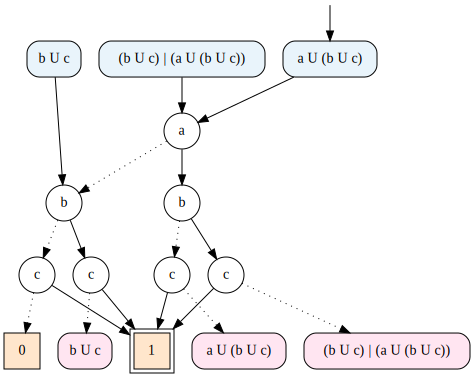

In [6]:
spot.ltlf_to_mtdfa("a U b U c", False, False)



Different LTLf formulas can have the same MTBDD representation. Above, we can see that $tr(a \mathbin{\mathsf{U}} (b \mathbin{\mathsf{U}} c))=tr((b \mathbin{\mathsf{U}} c) \lor a \mathbin{\mathsf{U}} (b \mathbin{\mathsf{U}} c))$.

Since the successors of these states are identical, it makes sense to fuse them.  This is actually what `ltlf_to_mtdfa()` does by default.

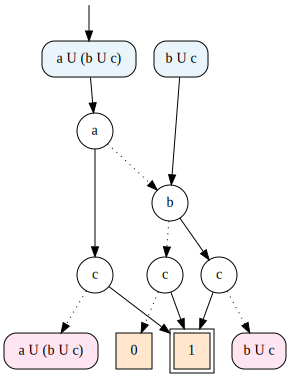

In [7]:
aut1 = spot.ltlf_to_mtdfa("a U b U c")
aut1

When fusing states, we must be cautious about the acceptance of these states.

Here is an example where this is clearly visible:

In [8]:
display_inline(spot.ltlf_to_mtdfa("GFa", False, False), spot.ltlf_to_mtdfa("GFa"))

Here, $(\mathop{\mathsf{F}}a)\land (\mathop{\mathsf{G}}\mathop{\mathsf{F}}a)$ and $\mathop{\mathsf{G}}\mathop{\mathsf{F}}a$ are equivalent, so the algorithm simply remembers the first formula it has seen.  Distinguishing the acceptance of the terminal nodes is not a problem.

**Implementation details:** A MTDFA is represented using two arrays:
- `formula names[n];`
- `bdd states[n];`


The MTBDD stored in `states[i]` encodes the outgoing edges of state `i`.  State 0 is always the initial state.    The terminal in those MTBDDs store integers of the form `2j+a` were `j` is the index of the destination state, and `a` is a boolean indicating whether that destination is accepting.  The `names` array is purely cosmetic: `names[i]` is the LTLf formula associated to state `i`, it can be used for rendering (`names` can be empty if one does not want to label the states).   

Automaton `aut1` above automaton has `n=2` roots for `a U b U c` and `b U c`, but one will usually want to consider `1` as a state.  The state for formula `1` is not stored, because it is always encoded as *true*.  (People who prefer to work with complete DFAs, might want to consider `0` as a state too.)  The `mtdfa` class has two methods to return its size: `num_roots()` counts the number of roots stored in the DFA (i.e., the size of the `states` and `names` array), and `num_states()` adds one to `num_roots()` if any root can reach `true`.

In [9]:
print(aut1.num_roots(), aut1.num_states())

2 3


# Propositional equivalence

The approach for building a MTDFA described above does not always terminate.

For instance consider $\varphi_1=(\mathop{\mathsf{G}}a) \mathbin{\mathsf{W}} (\mathop{\mathsf{G}}b)$.  The MTBDD constructed by $tr(\varphi)$ will contain a path labeled $a\land b$ with destination $term(\varphi_2, \top)$ where $\varphi_2=(\mathop{\mathsf{G}}b) \lor ((\mathop{\mathsf{G}}a) \land \varphi_1)$.  The formula MTBDD for $tr(\varphi_2)$ will in turn contain a path labeled by $a\land b$ with destination $term(\varphi_3, \top)$ where $\varphi_3=(\mathop{\mathsf{G}}b) \lor ((\mathop{\mathsf{G}}a) \land ((\mathop{\mathsf{G}}b) \lor ((\mathop{\mathsf{G}}a) \land \varphi_1)))$.  The series could continue indefinitely like this adding new terms as it progress.

To avoid this, we say that two LTLf formulas are propositionally equivalent iff, when we interpret their maximal subformulas starting with a temporal operator as if they were propositions, the two formulas are equivalent.
For instance formulas $\varphi_2$ and $\varphi_3$ are propositionally equivalent, because if we replace $\mathop{\mathsf{G}}a$, $\mathop{\mathsf{G}}b$, and $\varphi_1$ by the propositions $p_1$, $p_2$, and $p_3$ (respectively), we have:

$$
\begin{aligned}
  \varphi_2 &= p_2 \lor (p_1 \land p_3) \\
  \varphi_3 &= p_2 \lor (p_1 \land (p_2 \lor (p_1 \land p_3))) = p_2 \lor (p_1 \land p_3)
\end{aligned}
$$

The equivalence between these two Boolean formulas can easily be established by encoding them in BDDs.

The implementation keeps track of one BDD representing the "propositional representation" of each LTLf used in a terminal, and everytime it attempts to create $term(g,b)$, it will replace it by $term(f,b)$ if a formula $f$ propositionally equivalent to $g$ has already been seen.

Doing so ensure termination, because the formula we translate has a finite number $m$ of subformulas, and the set of Boolean combinations of those formulas has only $2^{2^m}$ propositionally-equivalent classes. 

**Aside:** Implementing this wasn't fun at all, because new terminals are created by a callback function called deep into the `apply` recursion.  Propositional equivalence has to be checked inside that recursion, but it also require running other BDD operations and creating new BDD variables...  So BuDDy had to learn how to run a BDD operation from within another BDD operation, and how to introduce new variables during a BDD operation.

In [10]:
# The `ltlf_translator` class (which provide the machinery used by the 
# ltlf_to_mtdfa() function) has a propeq_representative().  That function
# keep tracks of all function on which it is applied, and will return
# the first such function that is equivalent to its argument.
tmp = spot.ltlf_translator(spot._bdd_dict)
display(tmp.propeq_representative("Ga W Gb"))
display(tmp.propeq_representative("Gb | (Ga & (Ga W Gb))"))
display(tmp.propeq_representative("Gb | (Ga & (Gb | (Ga & (Ga W Gb))))"))
del tmp

spot.formula("Ga W Gb")

spot.formula("Gb | (Ga & (Ga W Gb))")

spot.formula("Gb | (Ga & (Ga W Gb))")

# Simplifying terminals

In an earlier example, we have seen that the translation of $\mathop{\mathsf{G}}\mathop{\mathsf{F}}a$ produces two different states labeled by $\mathop{\mathsf{G}}\mathop{\mathsf{F}}a$ and $\mathop{\mathsf{F}}a\land\mathop{\mathsf{G}}\mathop{\mathsf{a}}$.  These two states have exactly the same MTBDD encoding, so that can be detected and fixed in a second pass after the translation.  The only problem is that we did have to translate both formulas into MTBDDs.

The situation can get a lot worse: $\bigwedge_{i=1}^n \mathop{\mathsf{G}}\mathop{\mathsf{F}}p_i$ will create $2^n$ different terminals, but all these terminal are labeled by formulas that translate identically.

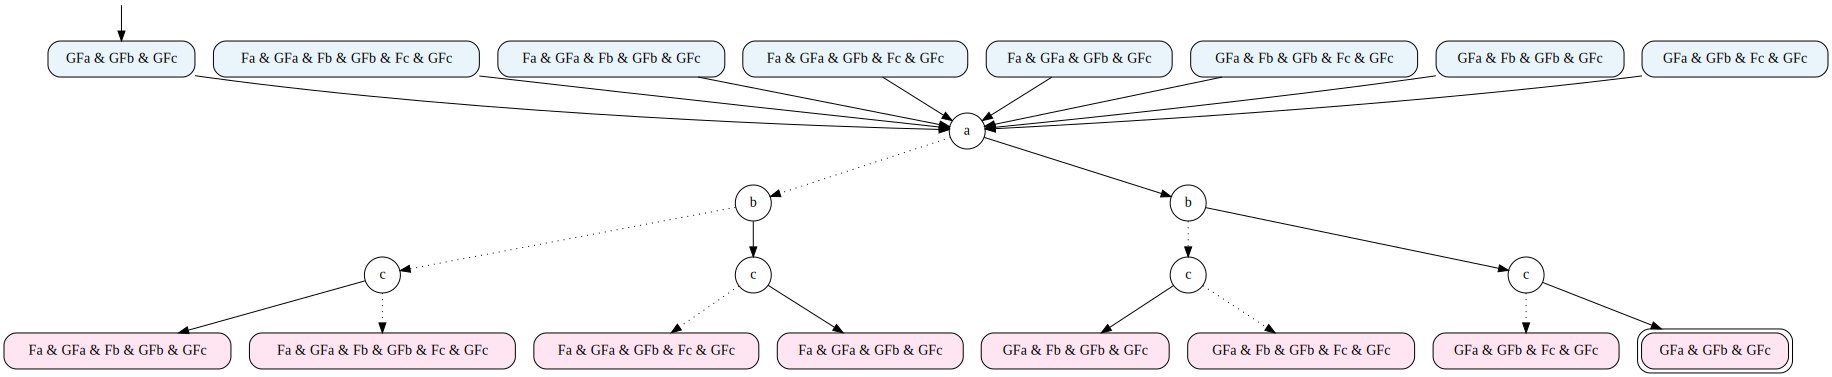

In [11]:
spot.ltlf_to_mtdfa("GFa & GFb & GFc", False, False)

To avoid that, the `propeq_representative` function, that is already applied to each terminal formula to detect if it is propositionally equivalent to a previous formula, also implements the following cheap simplifications:

$$
\begin{aligned}
      (\alpha \mathbin{\mathsf{U}} \beta)\lor \beta &\equiv \alpha \mathbin{\mathsf{U}} \beta \\
      (\alpha \mathbin{\mathsf{W}} \beta)\lor \beta &\equiv \alpha \mathbin{\mathsf{W}} \beta \\
      (\alpha \mathbin{\mathsf{M}} \beta)\land \beta &\equiv \alpha \mathbin{\mathsf{M}} \beta \\
      (\alpha \mathbin{\mathsf{R}} \beta)\land \beta &\equiv \alpha \mathbin{\mathsf{R}} \beta \\
      (\mathop{\mathsf{F}}\beta) \lor \beta &\equiv \mathop{\mathsf{F}}\beta \\
      (\mathop{\mathsf{G}}\beta) \land \beta &\equiv \mathop{\mathsf{G}}\beta
\end{aligned}
$$

There is one such rule for each temporal operator, for a pattern likely to occur in the output of $tr(\cdot)$.

In [12]:
spot.ltlf_translator(spot._bdd_dict).propeq_representative("GFa & GFb & GFc & Fa & Fb")

spot.formula("GFa & GFb & GFc")

In practice, for the $\bigwedge_{i=1}^n \mathop{\mathsf{G}}\mathop{\mathsf{F}}p_i$ formula mentionned above, those rules reduce all terminals to the input formula, causing a single state to be created.  And there are no identical state to merges aferwards.

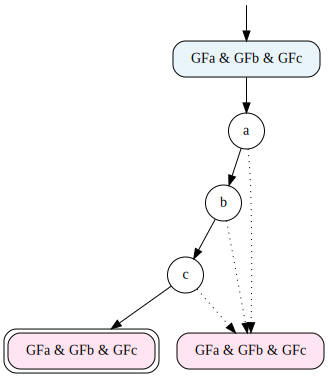

In [13]:
spot.ltlf_to_mtdfa("GFa & GFb & GFc", 
                   False,   # fusing states with identical MTBDD is disabled 
                   True)    # simplification of terminal formulas is enabled

# Detecting empty or universal translations

If the result of the translation has no accepting terminal (including true), or if it has no rejecting terminal (including false), then the formula is equivalent to true or false, and the automaton can be simplified to have a single state.

This simplification is enabled by default.  Here is an example when we disable it:

In [14]:
f = "!i1 & F(o1 & X[!]!o1 & (!o2 | (!o0 & !o1) | Go1 | (o0 & !o2 & X[!]!o0) | (!o0 & (!i0 | !i1) & X[!]!o0) | (!o1 & (i0 | !i1) & X[!]!o1) | (i0 & Go0))) & G(i1 | o2 | X[!]!i1) & G(!i1 | F!i1) & G(!o2 | X[!]i1)"
spot.ltlf_to_mtdfa(f, True, True, False).show(labels=False)

By default, the translation will build the above, realize it has no accepting terminal, and therefore return a "false" automaton instead.   

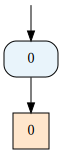

In [15]:
spot.ltlf_to_mtdfa(f)

# Conversion from MTDFA to TwA

TwA is the standard data-structure of Spot used to represent ω-automata.  
Since Spot has no class for representing DFA explicitely, this conversion is just a hack to allow a more traditional representation where we just ignore the acceptance condition.

The conversion to transition-based acceptance is straightfoward: each root of the MTBDD corresponds to a state, and each path from a root to a terminal corresponds to a transition, and that transition is accepting iff the terminal is odd.  Paths going to the *true* BDD constant become transitions leading to an accepting sink.

With transition-based DFA, a word is accepted if its last letter was read by a transition marked with a ⓿.

The conversion to state-based acceptance is not more difficult: the acceptance is simply pushed onto the destination state.

Below, the `as_twa()` returns a transition-based automaton by default.  `as_twa(True)` asks for a state-based output.

In [16]:
display_inline(aut1.as_twa(), aut1.as_twa(True))

In [17]:
aut2 = spot.ltlf_to_mtdfa("GFa")
display_inline(aut2.as_twa(), aut2.as_twa(True))

# More examples

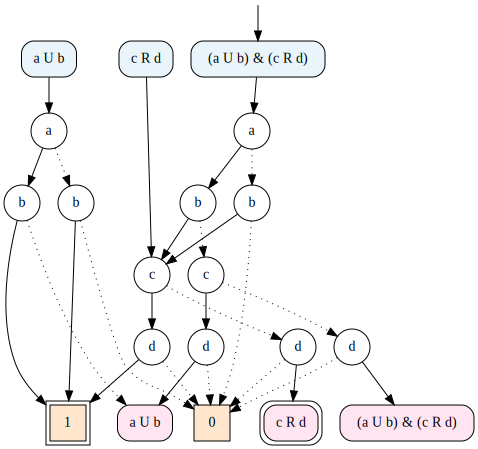

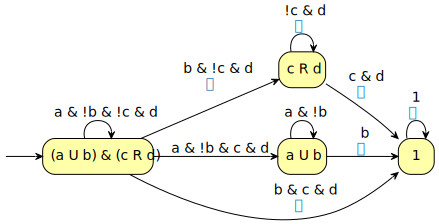

In [18]:
a1 = spot.ltlf_to_mtdfa("(a U b) & (c R d)") 
display(a1, a1.as_twa())

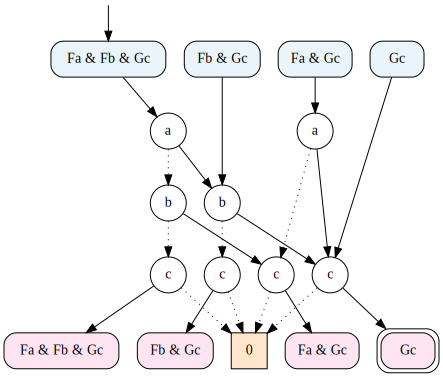

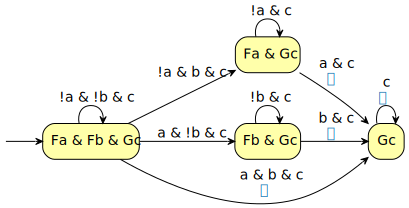

In [19]:
a2 = spot.ltlf_to_mtdfa("Fa & Fb & Gc") 
display(a2, a2.as_twa())

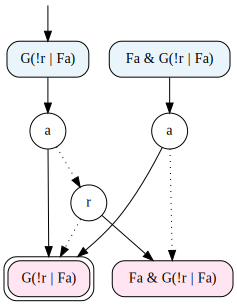

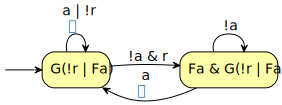

In [20]:
a3 = spot.ltlf_to_mtdfa("G(!r | Fa)") 
display(a3, a3.as_twa())

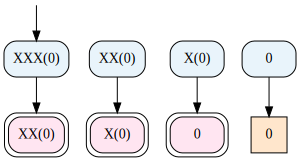

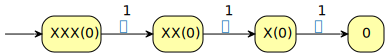

In [21]:
a4 = spot.ltlf_to_mtdfa("XXX(0)") 
display(a4, a4.as_twa())

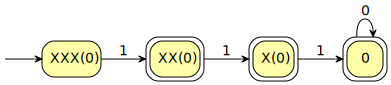

In [22]:
# because Spot only support transition-based acceptance internally, 
# it has to add a false self-loop whenever he needs to emulate 
# state-based acceptance on a state without successor.
display(a4.as_twa(True))

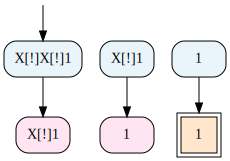

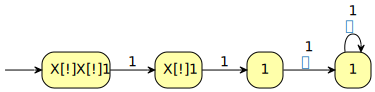

In [23]:
a5 = spot.ltlf_to_mtdfa("X[!]X[!]1") 
display(a5, a5.as_twa())

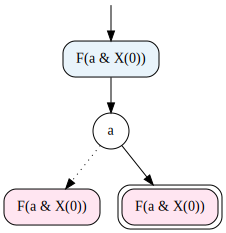

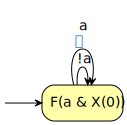

In [24]:
# The last step has to match "a".  This is equivalent to GFa or FGa in LTLf.
a6 = spot.ltlf_to_mtdfa("F(a & X(0))") 
display(a6, a6.as_twa())

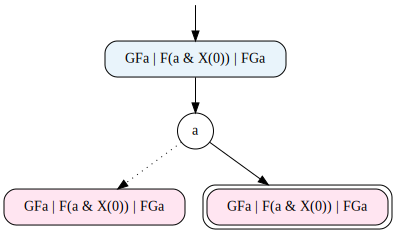

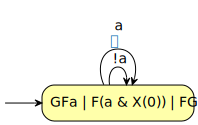

In [25]:
# same as above
a7 = spot.ltlf_to_mtdfa("F(a & X(0)) | GFa | FGa") 
display(a7, a7.as_twa())

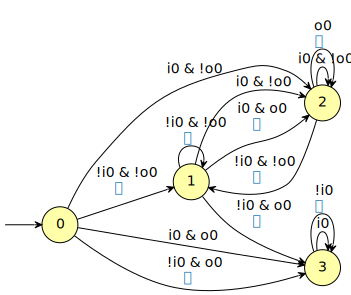

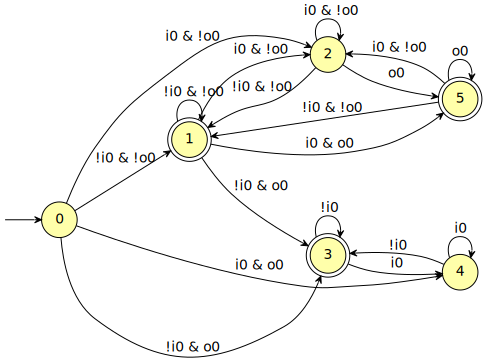

In [26]:
# lily09 -- without labels because formulas are too long (hover over the nodes to see them)
a8 = spot.ltlf_to_mtdfa("GFi0 -> (!o0 & G(!o0 -> ((!o0 U i0) & (i0 -> Fo0))) & GFo0)")
display(a8.show(labels=False), a8.as_twa(False, False), a8.as_twa(True, False))

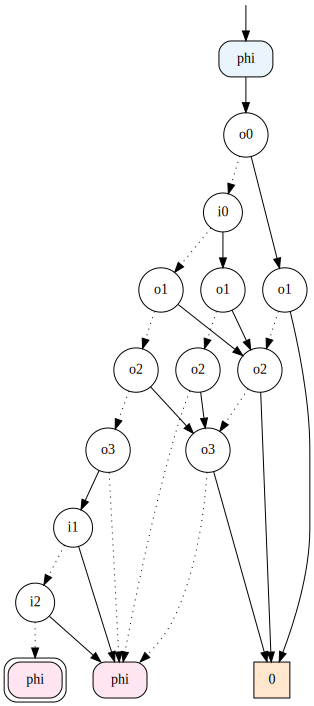

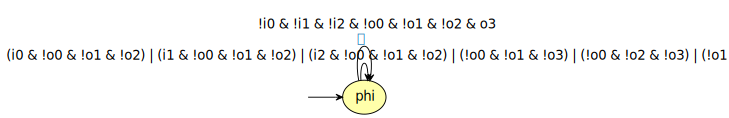

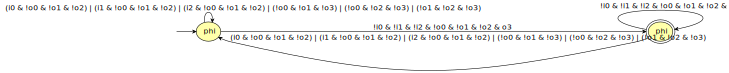

In [27]:
# lily18 -- without labels because formulas are too long
phi = "G(!(o0 & o1) & !(o0 & o2) & !(o0 & o3) & !(o1 & o2) & !(o1 & o3) & !(o2 & o3)) & (GFi0 -> GFo0) & (GFi1 -> GFo1) & (GFi2 -> GFo2) & GFo3"
a9 = spot.ltlf_to_mtdfa(phi)
a9.names[0] = spot.formula("phi") # Rename the formula for cosmetics
display(a9, a9.as_twa(), a9.as_twa(True))

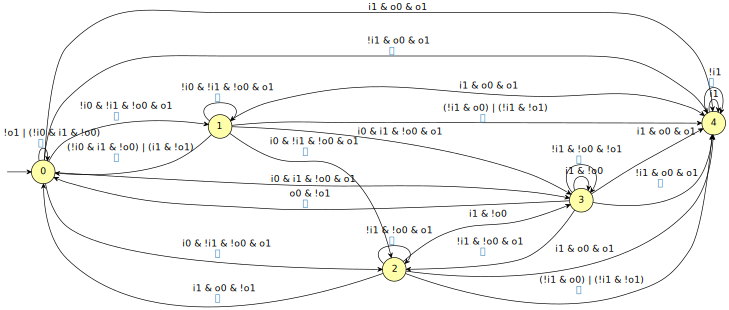

In [28]:
# lily19 -- without labels because formulas are too long  (hover on the states to read them)
f = "GFi1 -> G(o1 -> (!(o0 & o1) & (o1 U i1) & (o0 -> (o0 U i1)) & (i0 -> Fo0) & Fo1))"
a11 = spot.ltlf_to_mtdfa(f)
display(a11.show(labels=False), a11.as_twa(False, False))

On the above example, we can see how transition-based acceptance can save three states (copies of 0, 2, and 4).  Here is the state-based version for comparison.

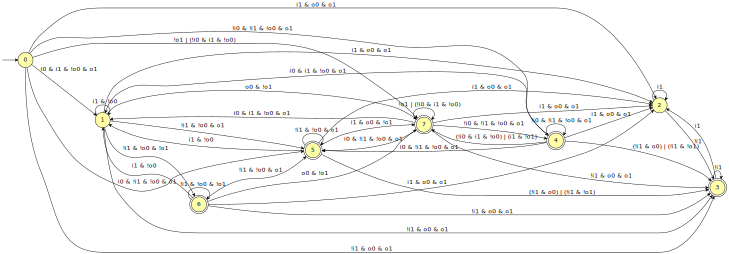

In [29]:
spot.translate(f, "finite", "deterministic")

# DFA Minimization

The MTBDD-based DFA allows a very simple implementation of minimization by partition refinement, similar to what is used in Mona.

  1. Assume all terminal belong to the same class, numbered 0.
  2. Rewrite all MTBDDs by relabeling each terminal by its class number (preserving the acceptance bit)
  3. Group all states in new classes according to their new BDD representation, giving each class a new number.
  4. Loop to 2 until the number of classes is stable.

For the purpose of the above algorithm, *false*, and *true* should treated as terminals (i.e., assigned a class and rewritten).  The the actual implementation then performs a final pass on the result to put *false* and *true* back.

Let's find some formulas on which this minimization is effective by trying the examples from [Lily](http://www.ist.tugraz.at/staff/jobstmann/lily/).

In [30]:
import spot.gen as sg
from timeit import default_timer as timer

In [31]:
print("           states                    time          ")
print("       -------------     --------------------------")
print("       DFA  min  ref        DFA  DFA+min        ref")
for i, f in enumerate(sg.ltl_patterns(sg.LTL_LILY_PATTERNS)):
    t1 = timer()
    dfa = spot.ltlf_to_mtdfa(f)
    t1b = timer()
    mindfa = spot.minimize_mtdfa(dfa)
    t2 = timer()    
    n1, n2 = dfa.num_states(), mindfa.num_states()
    mark = ">" if n1 > n2 else " "
    t3 = timer()
    ref = spot.translate(f, "finite", "deterministic", xargs="tls-impl=0")
    t4 = timer()    
    refsz = ref.num_states()
    t1b -= t1
    t2 -= t1
    t4 -= t3
    tmark = '='
    if t4 > t2: tmark = "<"
    elif t4 < t2: tmark = ">"
    
    # While we are there, let's control that mindfa ≡ ref.
    # We can do that by checking the emptiness of mindfa XOR ref.
    assert spot.product_xor(mindfa, spot.twadfa_to_mtdfa(ref)).is_empty()
    
    print(f"lily{i+1:<3} {n1:2} {mark} {n2:2}   {refsz:2}   {t1b * 1000:6.2f}ms {t2 * 1000:6.2f}ms {tmark} {t4 * 1000:6.2f}ms")    

           states                    time          
       -------------     --------------------------
       DFA  min  ref        DFA  DFA+min        ref
lily1    6    6    7     0.16ms   0.18ms <   0.58ms
lily2    9    9   12     0.07ms   0.10ms <   0.68ms
lily3   13   13   14     0.09ms   0.12ms <   1.63ms
lily4   21   21   23     0.19ms   0.26ms <   1.95ms
lily5   16   16   19     0.18ms   0.25ms <   1.64ms
lily6   25   25   30     0.14ms   0.20ms <   2.45ms
lily7    8    8    9     0.06ms   0.09ms <   0.68ms
lily8    1    1    2     0.02ms   0.04ms <   0.20ms
lily9    4    4    6     0.04ms   0.05ms <   0.27ms
lily10   4    4    7     0.03ms   0.04ms <   0.52ms
lily11   4    4    4     0.04ms   0.06ms <   0.35ms
lily12   8 >  6    7     0.05ms   0.07ms <   0.45ms
lily13   2    2    2     0.02ms   0.04ms <   0.21ms
lily14   1    1    2     0.03ms   0.05ms <   1.04ms
lily15   8    8    9     0.05ms   0.07ms <   0.78ms
lily16  22   22   23     0.13ms   0.18ms <   3.26ms
lily17   1  

The columns labeled DFA refer to the MTDFA construction, and show the number of states and time of the construction.

The columns labeled min refer to the minimized MTDFA; the time includes the time of the translation.

The "ref" column refers to the historical LTLf->LTL->DBA->DFA pipeline, that produces a state-based minimal DFA.  (Note that this pipeline performs some LTL simplification on the LTL formula prior to translation to DBA. The LTLf->MTDBA construction does not do any such simplification. The `tls-impl=0` option disables implication-based simplifications, to save some time.)

Both `min` and `ref` are minimal, but the former uses transition-based acceptance while the latter uses state-based acceptance.

Here is the only instance where minimization is useful:

In [32]:
def showlily(n, labels=False):
    f = sg.ltl_pattern(sg.LTL_LILY_PATTERNS, n) 
    print("-- before minimization --\n")
    aut = spot.ltlf_to_mtdfa(f)
    display(aut.show(labels=labels), aut.as_twa(False, labels))
    print("-- after minimization --\n")
    minaut = spot.minimize_mtdfa(aut)
    display(minaut.show(labels=labels), minaut.as_twa(False, labels))

-- before minimization --



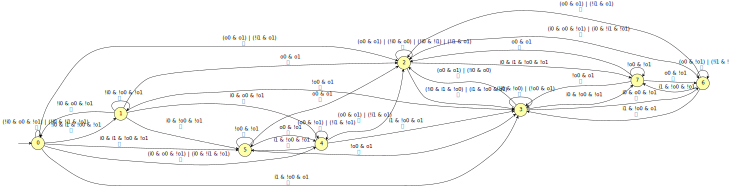

-- after minimization --



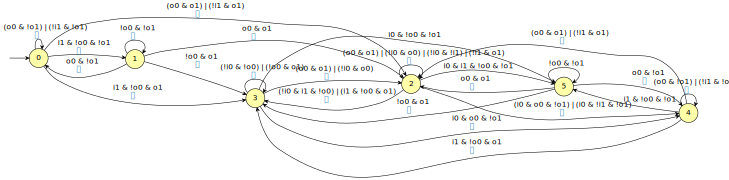

In [33]:
showlily(12)

# Minimal MTDFA does not imply minimal state-based DFA

An MTDFA is transition-based in nature, because the acceptance can be different on each path from a root.  

Although there is an easy interpretation of the MTDFA as a state-based DFA, the following shows that the state-based automaton one obtains from a minimial MTDFA is not necessarily minimal itself.  Here, the minimial transition-based DFA `autA`, obtained via this approach, has 8 states.   The state-based automaton obtained from that automata, `autB`, has 12 states.  But the minimial state-based DFA computed using the historical LTLf->LTL->DBA->DFA pipeline has 9 states.

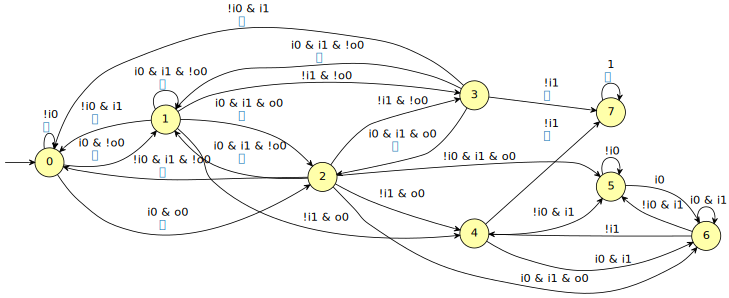

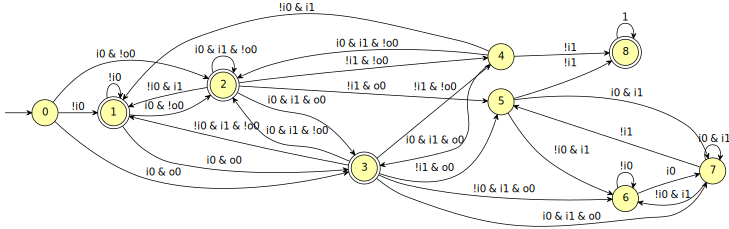

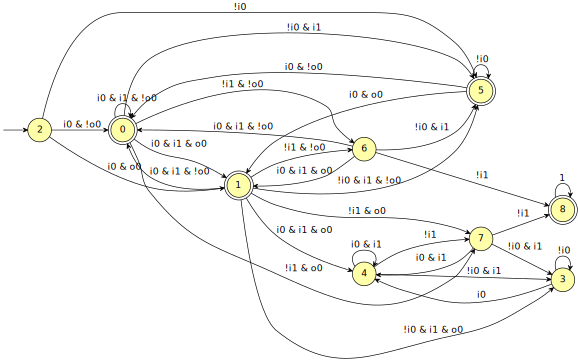

In [34]:
lily07 = "G(i0->X(i1|Xi1))->G(i0->(X(!o0 U i1)&(o0->X!o0)&(i2->(i0|o0|X(i0|o0|X(i0|o0|X(i0|o0)))))))"
l07 = spot.ltlf_to_mtdfa(lily07)
l07 = spot.minimize_mtdfa(l07)
# Get rids of formula labels, as they are too large
l07.names.clear()
autA = l07.as_twa(False)
autB = l07.as_twa(True)
autC = spot.translate(lily07, "finite", "deterministic")
# Ensure equivalence between l07 and aut.
assert spot.product_xor(l07, spot.twadfa_to_mtdfa(autC)).is_empty()
display(autA, autB, autC)

# Examples that caused problems to the minimization at some point

Let's keep these examples so that the notebook can serve as a test suite.

This large automaton reduces to false because it has no accepting terminals.  `ltlf_to_mtdfa()` will detect that and return false already (unless we disable the optimization as done below), but the minimization should also achieve that.

In [35]:
f = "!i1 & F(o1 & X[!]!o1 & (!o2 | (!o0 & !o1) | Go1 | (o0 & !o2 & X[!]!o0) | (!o0 & (!i0 | !i1) & X[!]!o0) | (!o1 & (i0 | !i1) & X[!]!o1) | (i0 & Go0))) & G(i1 | o2 | X[!]!i1) & G(!i1 | F!i1) & G(!o2 | X[!]i1)"
dfa = spot.ltlf_to_mtdfa(f, True, True, False)
display(dfa.show(labels=False))
spot.minimize_mtdfa(dfa).show(labels=False)

Because the minimization has to turn constants false and true to terminals, it is a bit tricky to turn the terminal back into false/true especially in automata were "accepting false" or "rejecting true" are used, because these two have to be kept as terms.  The following translations used to highlight issues with previous implementations of the minimization.

In [36]:
a = spot.ltlf_to_mtdfa("X[!](1) | Ga")
display_inline(a, spot.minimize_mtdfa(a))

In [37]:
a = spot.ltlf_to_mtdfa("X[!](b & X[!](1)) | Ga | X[!](c & X[!]X(0))")
display_inline(a.show(labels=True), spot.minimize_mtdfa(a))

In [38]:
a = spot.ltlf_to_mtdfa("X(0) | Ga")
display_inline(a.show(labels=True), spot.minimize_mtdfa(a))

# Boolean operations on MTDFAs

The cross-product of two MTDFAs can be done combining the initial MTBDDs of the two MTDFAs in such a way that the terminal of the product represent pairs of states of the original formulas.  

The combination function used can implement any Boolean operation.  In practice the Boolean operation just changes the way the acceptence of the new terminal is defined.  Using $term(s_\ell,b_\ell)$ represent a terminal for state $s_\ell$ in the left automaton, and $term(s_r,b_r)$ is a terminal in the right automaton, then for a Boolean operator $\odot$ we combine MTBDD using the rule $term(s_\ell,b_\ell)\odot term(s_r,b_r) = term((s_\ell,s_r),b_\ell \odot b_r)$.

Once we have computed MTBDDs for all pairs $(s_\ell,s_r)$ appearing in terminals that can be transitively reached this way, we can compute the names of all the states associated to those pairs.

The following Boolean functions are available:
  - `product()`  implements $\land$
  - `product_or()`  implements $\lor$
  - `product_xor()`  implements $\oplus$
  - `product_xnor()`  implements $\leftrightarrow$
  - `product_implies()`  implements $\rightarrow$

Except for `product_implies`, the other functions are already defined for the `twa` class.

Let's build three base MTDFAs so that we can combine them.

In [39]:
gfa = spot.ltlf_to_mtdfa("GFa")
aub = spot.ltlf_to_mtdfa("a U b")
xxc = spot.ltlf_to_mtdfa("XXc")
display_inline(gfa, aub, xxc)

In [40]:
display_inline(spot.product(gfa, aub), spot.product_or(gfa, aub))

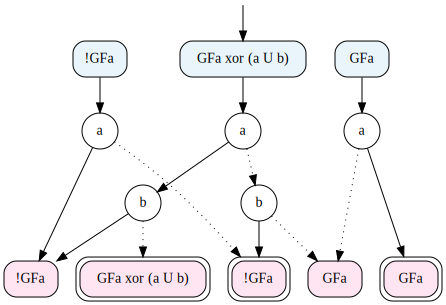

In [41]:
spot.product_xor(gfa, aub)

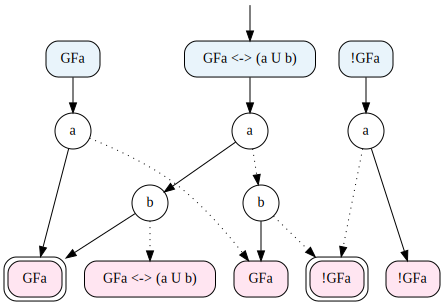

In [42]:
spot.product_xnor(gfa, aub)

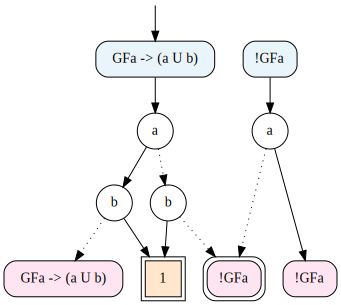

In [43]:
spot.product_implies(gfa, aub)

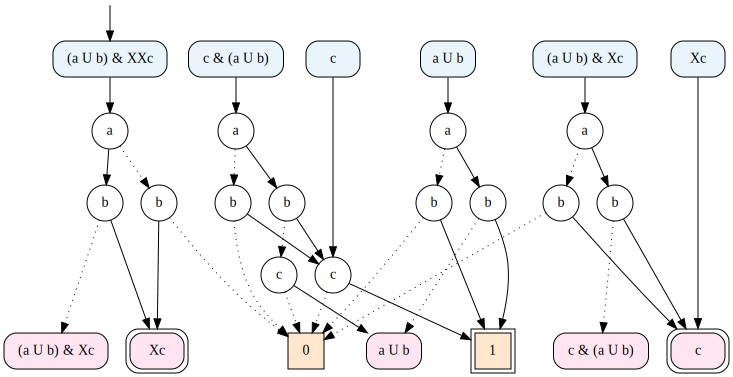

In [44]:
spot.product(aub, xxc)

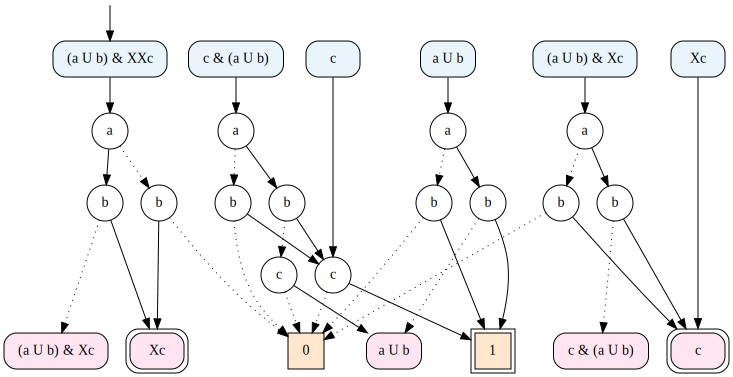

In [45]:
# The above (obtained by product) is similar to what we get by direct translation
spot.ltlf_to_mtdfa("(a U b) & XXc")

Additionally, `complement()` does what's expected: accepting terminals become non-accepting and vice-versa.  Formula labels are also negated for looks.

In [46]:
display_inline(aub, spot.complement(aub))

# Converting from TwA to MTDFA

The helper function `spot.twadfa_to_mtdfa()` can be used to convert a TwA representing a DFA into MTDFA.  It should work if the inpt TwA is state-based (as in next cell), or transition-based (three cells down).

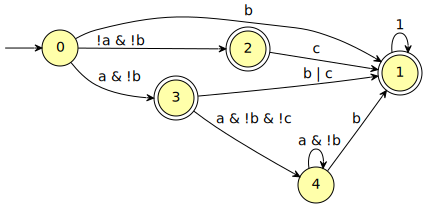

In [47]:
a = spot.translate("(a U b) | Xc", "finite", "deterministic")
a

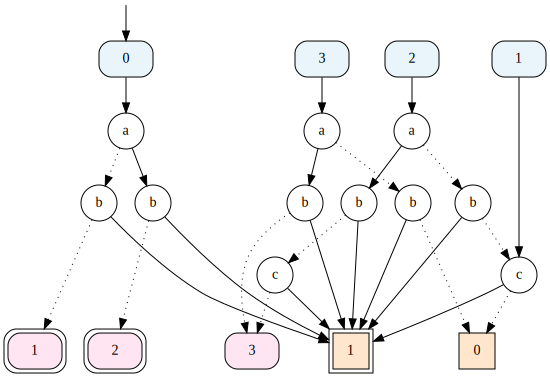

In [48]:
a2 = spot.twadfa_to_mtdfa(a)
a2

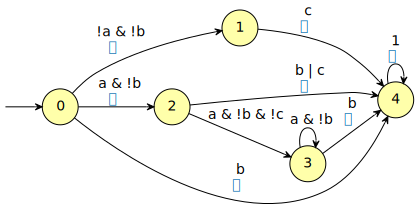

In [49]:
a3 = a2.as_twa(False, False)
a3

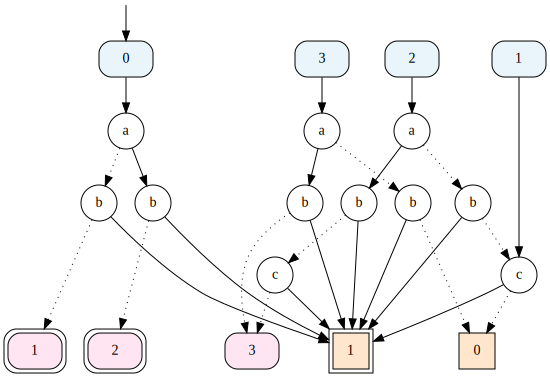

In [50]:
a4 = spot.twadfa_to_mtdfa(a3)
a4

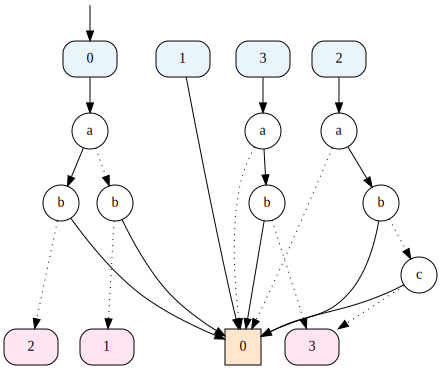

True


In [51]:
# We can check that a2 and a4 are equivalent by checking the emptiness of a2 XOR a4.
p = spot.product_xor(a2, a4)
display(p)
print(p.is_empty())

# Compositional translation

`ltlf_to_mtdfa()` translate an entire formula at once, using the $tr(\cdot)$ function defined above.  The resulting MTDFA can then be minimized if desired.

`ltlf_to_mtdfa_compose()` implements a compositional approach in which maximal subformulas that starts with a temporal operator are first translated and minimized separately, and the resulting minimial MTDFA are then combined recursively according to the Boolean operators that connect those formula.

For instance in the formula $\lnot\mathop{\mathsf{G}}(i_1\rightarrow \mathop{\mathsf{F}}o)\land \lnot\mathop{\mathsf{G}}(i_2\rightarrow \mathop{\mathsf{F}}o)$, `ltlf_to_mtdfa_compose()` will first call
`ltlf_to_mtdfa()` to translate $\mathop{\mathsf{G}}(i_1\rightarrow \mathop{\mathsf{F}}o)$ and $\mathop{\mathsf{G}}(i_2\rightarrow \mathop{\mathsf{F}}o)$ separately.  Then those two automata will be minimized.  Then they will be both complemented and combined with `product()`, and finially the result of the product will be minimized again.  Minimizing at every step like this can help keep the automaton small, and avoid the quadratic cost of running minimization on a very large automaton at the end of the translation.

In practice, the compositional approach works very well on benchmarks that have been built in a compositional way, for instance conjunctions of random formulas.

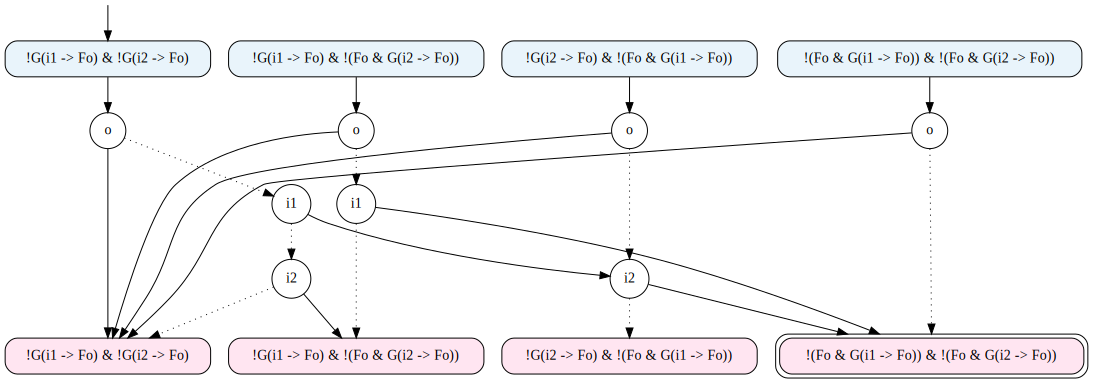

In [52]:
f = spot.formula("!G(i1 -> Fo) & !G(i2 -> Fo)")
spot.ltlf_to_mtdfa_compose(f)

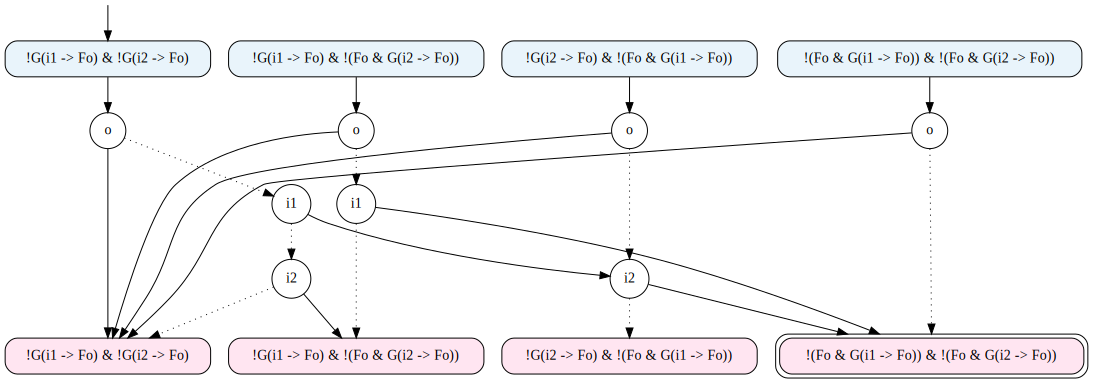

In [53]:
spot.ltlf_to_mtdfa(f)